In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Requirements

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
import numpy as np
!pip install transformers
from transformers import pipeline
from transformers import TFAutoModel
!pip install datasets
from datasets import Dataset, DatasetDict
!pip install tensorflow
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.1 MB/s 
     |████████████████████████████████| 6.6 MB 42.6 MB/s 
     |████████████████████████████████| 101 kB 13.3 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.3 MB/s 
     |████████████████████████████████| 140 kB 58.1 MB/s 
     |████████████████████████████████| 1.1 MB 55.1 MB/s 
     |████████████████████████████████| 212 kB 64.0 MB/s 
     |████████████████████████████████| 127 kB 61.7 MB/s 
     |████████████████████████████████| 271 kB 68.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |█████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

we load the data that we gathered in first phase, and split to train and test. then we have 2 seperated dataframes for train and test. 
IMPORTANT: we shouldn't have any null values in this dataframe.

In [ ]:
df = read_csv('drive/MyDrive/NPL-Project-Data/dataset.csv')
df = df.dropna()
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True)
test_df = test_df.reset_index()

# Noisy Channel

The noisy channel model is a framework used in natural language processing (NLP) to identify the correct word in situations where it is unclear. The framework helps detect intended words for spell checkers, virtual assistants, translation programs, question answering systems and speech to text software.

In [ ]:
import nltk
from nltk.corpus import words
nltk.download('words')
nltk.download('punkt')

!pip install wordfreq
from wordfreq import word_frequency

import operator
import random

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


we want to find minimum number operations to convert str1 to str2. 

In [ ]:
def edit_distance(str1, str2):
	
	len1 = len(str1)
	len2 = len(str2)

	# Create a DP array to memoize result
	# of previous computations
	DP = [[0 for i in range(len1 + 1)]
			for j in range(2)];

	# Base condition when second String
	# is empty then we remove all characters
	for i in range(0, len1 + 1):
		DP[0][i] = i

	# Start filling the DP
	# This loop run for every
	# character in second String
	for i in range(1, len2 + 1):
		
		# This loop compares the char from
		# second String with first String
		# characters
		for j in range(0, len1 + 1):

			# If first String is empty then
			# we have to perform add character
			# operation to get second String
			if (j == 0):
				DP[i % 2][j] = i

			# If character from both String
			# is same then we do not perform any
			# operation . here i % 2 is for bound
			# the row number.
			elif(str1[j - 1] == str2[i-1]):
				DP[i % 2][j] = DP[(i - 1) % 2][j - 1]
			
			# If character from both String is
			# not same then we take the minimum
			# from three specified operation
			else:
				DP[i % 2][j] = (1 + min(DP[(i - 1) % 2][j],
									min(DP[i % 2][j - 1],
								DP[(i - 1) % 2][j - 1])))
			
	# After complete fill the DP array
	# if the len2 is even then we end
	# up in the 0th row else we end up
	# in the 1th row so we take len2 % 2
	# to get row
	return DP[len2 % 2][len1]

in this cell, we first store a set that is included all the english words in nltk dictionary. 
then we have a method that find all the words that has the minimum distant to the input token. for example if the input token is wa, it finds was and war and ...

In [ ]:
# to find closest options for a token
english_words_set = set(words.words())

def min_distants(token):
  min_dist = len(token)
  candidates = []
  candidate_distants = []
  for w in english_words_set:
    d = edit_distance(token, w)
    if d<min_dist:
      candidates.append(w)
      candidate_distants.append(d)
      min_dist = d
  if len(candidates)==0:
    return token
  
  min_dist = min(candidate_distants)
  final_candidates = []
  for i in range(len(candidate_distants)):
    if candidate_distants[i] == min_dist:
      final_candidates.append(candidates[i])
  return final_candidates

this method tries to find the most probable replacement for a token. so it has 3 options:


1.   if that token has a meaning, then we return itself.
2.   if that there is only 1 word that has minimum distance to the token, then we return that word.
3.   if there are multi candidates, then we return the word that is most frequent instead of the token.



In [ ]:
# return the item that is most frequent
def correct_token(token):
  if token in english_words_set:
    return token
  
  candidates = min_distants(token)
  if len(candidates)==1:
    return candidates[0]


  candidates_frequency = {}
  for c in candidates:
    candidates_frequency[c] = word_frequency(c, 'en')
  return max(candidates_frequency.items(), key=operator.itemgetter(1))[0]

this method just inputs a sentence and calls correct_token for each of it tokens.

In [ ]:
def spell_correct(text):
  tokenizer = nltk.tokenize.TreebankWordTokenizer()
  tokens = tokenizer.tokenize(text)
  new_tokens = [correct_token(t) for t in tokens]
  return ' '.join(new_tokens)

here select some random tests (because it is so slow and we can't run it for 45000 tests.
and then we see how the model corrects it.

In [ ]:
def evaluate(samples_number):
  true_count = 0
  total_count = 0
  while total_count<samples_number:
    r = random.randint(0, test_df.shape[0])
    text = test_df['noise_sentence'][r]
    if(len(text)>120):
      continue
    print(text)
    corrected = spell_correct(text)
    print(corrected)
    print(test_df['label'][r])
    if test_df['label'][r].lower()==corrected.lower():
      true_count += 1
      print(True)
    total_count += 1
    print('-----------------------------\n')
  print('ACCURACY:', true_count/samples_number)

In [ ]:
evaluate(5)

Therefore he fourth defining quality is the need for chage
therefore he fourth defiling quality is the need for change
Therefore the fourth defining quality is the need for change
-----------------------------

Legal abortionq performed in the developed world are among the sCfest prcoedures in hedicine
legal abortion performer in the developer world are among the infest procedure in helicine
Legal abortions performed in the developed world are among the safest procedures in medicine
-----------------------------

It can ocur as a rdsult of a infection or one acquired during pregnancy
Io can our as a result of a infection or one acquired during pregnancy
It can occur as a result of a infection or one acquired during pregnancy
-----------------------------

A thin fog si just dfnse enough to be illuminated by th ligbt that passes through the gaps in a structure or in a tree
A thin fog si just dense enough to be illuminated by th light that passus through the gyps in a structure or in a t

# RNNs

## Data Pre-processing

In [ ]:
# Create a dictionary to convert the vocabulary (characters) to integers
vocab_to_int = {}
count = 0
for row in df['noise_sentence']:
    for character in row:
        if character not in vocab_to_int:
            vocab_to_int[character] = count
            count += 1

In [ ]:
# Check the size of vocabulary and all of the values
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} characters.".format(vocab_size))
print(sorted(vocab_to_int))

The vocabulary contains 75 characters.
[' ', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{']


In [ ]:
# Create another dictionary to convert integers to their respective characters
int_to_vocab = {}
for character, value in vocab_to_int.items():
    int_to_vocab[value] = character

In [ ]:
# This method convert sentences to integers
def create_int_sentences(sentences, max_length = 100):
  int_sentences = []
  for sentence in sentences:
    int_sentence = []
    count = 0
    for character in sentence:
        if count>=max_length:
          break
        int_sentence.append(vocab_to_int[character])
        count+=1
    if len(int_sentence)<max_length:
      int_sentence = int_sentence + ([vocab_to_int[' ']]*(max_length-len(int_sentence)))
    int_sentences.append([int_sentence])
  return np.array(int_sentences)

create each of the required arrays with the above method.

In [ ]:
x_train = create_int_sentences(train_df['noise_sentence'][:180000])
y_train = create_int_sentences(train_df['label'][:180000])
x_test = create_int_sentences(test_df['noise_sentence'][:45000])
y_test = create_int_sentences(test_df['label'][:45000])

## Build model

these are some hyperparameters for our model:

if is_load = True, then we continue the training as before.

In [ ]:
input_size = 100
output_size = 100
dropout = 0.5
batch_size = 8
is_load = True

here we create a model and we can see its layers.

In [ ]:
if is_load:
  model = load_model('/content/drive/MyDrive/NPL-Project-Data/lstm_model.h5')
else:
  model = Sequential()
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True, dropout=dropout),
                          merge_mode='sum',
                          input_shape=(None, input_size)))
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True,
                              dropout=dropout), merge_mode='sum'))
  model.add(Bidirectional(LSTM(output_size, activation='relu', return_sequences=True,
                              dropout=dropout), merge_mode='sum'))
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 100)        160800    
 nal)                                                            
                                                                 
Total params: 482,400
Trainable params: 482,400
Non-trainable params: 0
_________________________________________________________________


fit the model and then save its weights because the training process is so long.

and we can see the chart of losses.

Epoch 1/3
22500/22500 [==============================] - 169s 7ms/step - loss: 56.4305 - mse: 56.4305 - val_loss: 56.6160 - val_mse: 56.6160
Epoch 2/3
22500/22500 [==============================] - 143s 6ms/step - loss: 56.3684 - mse: 56.3684 - val_loss: 57.8252 - val_mse: 57.8252
Epoch 3/3
22500/22500 [==============================] - 139s 6ms/step - loss: 56.3256 - mse: 56.3256 - val_loss: 56.7757 - val_mse: 56.7757


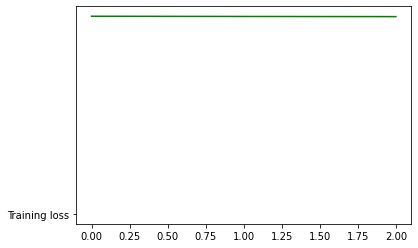

In [ ]:
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), batch_size=batch_size)
model.save('/content/drive/MyDrive/NPL-Project-Data/lstm_model.h5')
plt.plot(history.epoch, history.history['loss'], 'g', 'Training loss')

## Test a sample

In [ ]:
train_df['noise_sentence'][12]

'Modal theories of ability for example focus on what os possible for the agent to do'

In [ ]:
x_train[12]

array([[42,  5, 16, 11,  6, 16, 20, 17,  8,  3, 11, 17, 16, 11, 16,  6,
        10,  8, 17, 16, 15,  9,  8,  6, 11,  8, 10, 25,  8,  2, 11, 15,
         9,  8,  6, 15, 16, 17,  3, 26,  6, 11, 24,  8,  6, 14,  8, 18,
        16, 17, 21, 16,  6, 16, 20,  2, 18,  8,  6,  2,  3,  4,  6, 11,
        24, 13,  9, 10,  5,  4, 12,  3,  2, 10, 17, 20,  6, 11,  8, 10,
         8,  9,  2, 11, 15,  9,  8,  6, 15, 16,  3, 17, 26,  6, 11, 24,
         8,  6, 27,  8]])

In [ ]:
sample = x_train[12].reshape((1,1,100))
res = ''
for i in np.squeeze(sample):
  res+=int_to_vocab[i]
print(res)

res = ''
for i in np.squeeze(model.predict(sample)):
  res+=int_to_vocab[round(i)]
print(res)

# Transformers

In [ ]:
my_dataset = DatasetDict()
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df, split='test')
my_dataset['train'] = train_ds
my_dataset['test'] = test_ds
my_dataset

DatasetDict({
    train: Dataset({
        features: ['noise_sentence', 'label', '__index_level_0__'],
        num_rows: 180707
    })
    test: Dataset({
        features: ['index', 'noise_sentence', 'label'],
        num_rows: 45177
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def my_tokenize_function(examples):
    return tokenizer(examples["noise_sentence"], padding="max_length", truncation=True)

my_tokenized_datasets = my_dataset.map(my_tokenize_function, batched=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Parameter 'function'=<function my_tokenize_function at 0x7fc078c16c20> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/181 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tf_train_dataset = my_tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8,
)

tf_test_dataset = my_tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8,
)

In [ ]:
my_model = TFAutoModel.from_pretrained('murali1996/bert-base-cased-spell-correction', from_pt=True)

Downloading:   0%|          | 0.00/486 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/707M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer 


# Define the model repo
model_name = "murali1996/bert-base-cased-spell-correction" 


# Download pytorch model
model = TFAutoModel.from_pretrained('murali1996/bert-base-cased-spell-correction', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Transform input tokens 
inputs = tokenizer("Hello world! I am Arman and I really want to introduce you someting", return_tensors="tf")

# Model apply
outputs = model(**inputs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                                 <tf.Tensor: shape=(1, 18, 768), dtype=float32, numpy=
                                                 array([[[ 5.0882955 ,  0.10132137,  0.08653371, ..., -2.0413513 ,
                                                          -3.7453523 ,  4.7209005 ],
                                                         [ 1.5374068 , -3.776407  ,  5.5769663 , ...,  0.48342243,
                                                           4.187578  , -0.8234724 ],
                                                         [-0.3661089 ,  2.4145043 ,  3.6550782 , ..., -3.158326  ,
                                                           1.0045308 ,  2.1259544 ],
                                                         ...,
                                                         [ 2.2148838 ,  7.3402863 , -0.20207256, ..., -1.5187747 ,
                                                  